# Team BackProp
During exploration of the neural architecture, we used copies of this notebook to be able to easily process data whilst keeping our models intact. 

1. Import KMNIST Data
2. Data preprocess and augmentate
3. Develop neural network model
4. Cross validate model
    - At this stage we decide whether to keep the model for full training or remodify the network again to improve it.
5. Hyperparameter Tuning
6. Train on full dataset
7. Save model and submit

## Pipeline Setup

### Imports

In [0]:
!pip install pycm livelossplot
%pylab inline

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset 
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, RandomRotation,\
                                    ToPILImage, RandomResizedCrop, RandomAffine

from livelossplot import PlotLosses

import csv
import pickle

def set_seed(seed):
    """ Use this to set ALL the random seeds to a fixed value and take out any 
        randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    #uses inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
    torch.backends.cudnn.benchmark = False  
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'

if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

from google.colab import drive
drive.mount('/content/gdrive/')

Cuda installed! Running on GPU!


### KMNIST Data

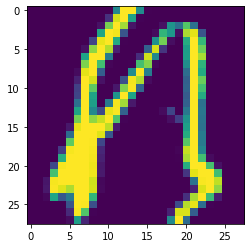

In [0]:
# Load in the datasets
X = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-imgs.npy") /255
y = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-train-labels.npy")
Xtest = np.load(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist-test-imgs.npy") /255

# Load in the classmap as a dictionary
classmap = {}
with open('/content/gdrive/My Drive/Colab Notebooks/Mini-Project/acse-module-8-19/kmnist_classmap.csv', 'r') as csvfile:
   spamreader = csv.reader(csvfile, delimiter=',')
   next(spamreader)
   for row in spamreader:
       classmap[row[0]] = row[2]

# Check if we imported correctly
plt.imshow(X[0]);

## Image Preprocessing and Augmentation

In [0]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None, mean=False, std=False):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data.reshape(-1,1,28,28)
        self.targets = targets
        self.transform = transform

        # Find mean and standard dev
        self.mean = mean
        self.std = std

        self.Rotation = Compose([
                                  ToPILImage(),
                                   RandomRotation(10),
                                   ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                ])

        self.RotandCrop = Compose([
                                  ToPILImage(),
                                   RandomResizedCrop(size=(28,28), scale=(0.8,1)),
                                  ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                 ])
        
        self.Affine = Compose([ToPILImage(),
                                   RandomAffine(10, shear=10),
                                   ToTensor(), Normalize(mean=[self.mean], std=[self.std])
                                ])
 
        
        self.Norm = Compose([Normalize(mean=[self.mean], std=[self.std])
                                 ])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        assert (self.mean != False), "Asign a mean"
        assert (self.mean != False), "Asign a std"
        
        if self.transform:
            x = random.random()
            if 0<= x<0.2: # rotate
              sample = self.Rotation(sample)
            if 0.2<= x<0.4: # resize crop
              sample = self.RotandCrop(sample)
            if 0.4<= x<0.7: # shear crop
              sample= self.Affine(sample)
              
            else: # none
              sample = self.Norm(sample)
        else:
           sample = self.Norm(sample)
            
        return sample, label

torch.Size([25, 1, 28, 28])
max: tensor(6.1103)


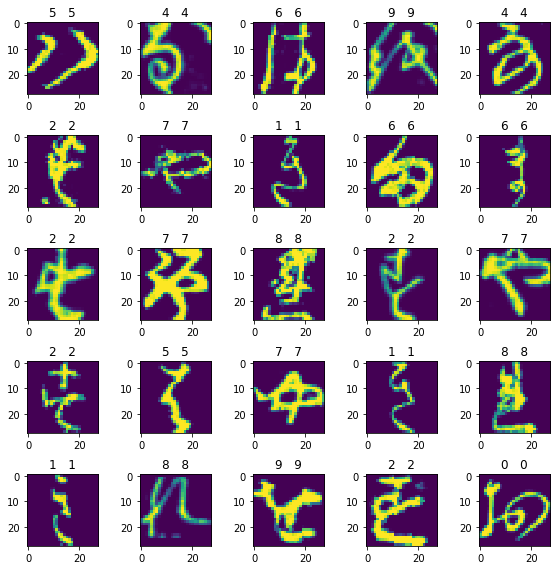

In [0]:
# Verify if image augmentation works:
X_train, y_train = X.astype(float), y
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train)
mean1, std1 = torch.mean(X_train), torch.std(X_train)
dset = CustomImageTensorDataset(X_train, y_train, transform=True, mean=mean1, std=std1 )

# Make a dataloader to access the PIL images of a batch size of 25
loader = DataLoader(dset, batch_size=25, shuffle=True)

# Create an iter object to cycle through dataloader
train_iter = iter(loader)
imgs, labels = train_iter.next()

print(imgs.shape)
print('max:',imgs.max())

# plot our batch of images with labels
fig, axarr = plt.subplots(5,5,figsize=(8,8))
fig.tight_layout()
for img, label, axs in zip(imgs, labels, axarr.flatten()):
    axs.set_title(str(label.numpy()) + "   " + str(label.numpy()))
    axs.imshow(img.numpy()[0])

## Model Development



### Architecture Analysis Models


In [0]:
class AlexNet_Exp1(nn.Module):
  """Based on the AlexNet paper with the same number of layers and parameters 
      are rescaled down by 8x to fit with the original alexnet image size to 
      our kmnist size ratio (227:28)
  """
  
  def __init__(self):
    super(AlexNet_Exp1, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=2, bias=True)
    self.conv_7 = nn.Conv2d(24, 16, kernel_size=3, stride=1, padding=2, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(400, 256, bias=True)
    self.output = nn.Linear(256, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp3(nn.Module):
  """Based on the AlexNet paper with the same number of layers and parameters 
      are rescaled down by 4x to better fit to the labels compared to 8x scaling
  """
  
  def __init__(self):
    super(AlexNet_Exp3, self).__init__()
    self.conv_1 = nn.Conv2d(1, 12, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(12, 32, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=2, bias=True)
    self.conv_7 = nn.Conv2d(48, 32, kernel_size=3, stride=1, padding=2, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(800, 512, bias=True)
    self.output = nn.Linear(512, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp4(nn.Module):
  """Based on the AlexNet paper with the same number of channels and layers 
      are rescaled down by 8x to fit with the original alexnet image size to 
      our kmnist size ratio (227:28)
      
      We have now provided a "reasonable" guess of the filters and paddings 
      
  """
  
  def __init__(self):
    super(AlexNet_Exp4, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1, bias=True)
    self.conv_7 = nn.Conv2d(24, 16, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(144, 128, bias=True)
    self.output = nn.Linear(128, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp5(nn.Module):
  """Based on the AlexNet paper with the same number of layers and parameters 
      are rescaled down by 8x but with an addional convolutional layer 
  """
  
  def __init__(self):
    super(AlexNet_Exp5, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=13, stride=1, padding=6, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=7, stride=1, padding=3, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2, bias=True)
    
    # additional layer
    self.conv_6 = nn.Conv2d(24, 24, kernel_size=5, stride=1, padding=2, bias=True)
    
    self.conv_7 = nn.Conv2d(24, 24, kernel_size=4, stride=1, padding=1, bias=True)
    self.conv_8 = nn.Conv2d(24, 16, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_9 = nn.MaxPool2d(kernel_size=2)
    self.linear_10 = nn.Linear(144, 100, bias=True)
    self.output = nn.Linear(100, 10, bias=True)
    
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    
    x = self.act(self.conv_6(x))
    
    x = self.act(self.conv_7(x))
    x = self.act(self.conv_8(x))
    x = self.pool_9(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_10(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp6(nn.Module):
  """ Based on the AlexNet paper with the same number of channels and layers 
      are rescaled down by 4x to fit with the original alexnet image size to 
      our kmnist size ratio (227:28)
      
      We have now provided a "reasonable" guess of the filters and paddings 
      
  """
  
  def __init__(self):
    super(AlexNet_Exp6, self).__init__()
    self.conv_1 = nn.Conv2d(1, 12, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(12, 32, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1, bias=True)
    self.conv_7 = nn.Conv2d(48, 32, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(288, 200, bias=True)
    self.output = nn.Linear(200, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp7(nn.Module):
  """Based on the AlexNet paper with the same number of channels and layers 
      are rescaled down by 8x to fit with the original alexnet image size to 
      our kmnist size ratio (227:28)
      
      +1 classification layer
      
      We provided a "reasonable" guess of the filters
      
  """
  
  def __init__(self):
    super(AlexNet_Exp7, self).__init__()
    self.conv_1 = nn.Conv2d(1, 6, kernel_size=11, stride=1, padding=3, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=2, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(16, 24, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1, bias=True)
    self.conv_7 = nn.Conv2d(24, 16, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_8 = nn.MaxPool2d(kernel_size=2)
    self.linear_9 = nn.Linear(144, 100, bias=True)
    self.linear_10 = nn.Linear(100, 70, bias=True)
    self.output = nn.Linear(70, 10, bias=True)
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_9(x))
    x = self.act(self.linear_10(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp8(nn.Module):
  """Based on the AlexNet paper: Modified the each part of the network
      +1 Conv layer
      +4 Classification layers
      +x4 parameters
      We have used a "reasonable" guess of the filters 
      
  """
  
  def __init__(self):
    super(AlexNet_Exp8, self).__init__()
    # Convolutional Layers
    self.conv_1 = nn.Conv2d(1, 12, kernel_size=13, stride=1, padding=6, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(12, 32, kernel_size=7, stride=1, padding=3, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(32, 48, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(48, 48, kernel_size=5, stride=1, padding=2, bias=True)    
    self.conv_7 = nn.Conv2d(48, 48, kernel_size=4, stride=1, padding=1, bias=True)
    self.conv_8 = nn.Conv2d(48, 32, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_9 = nn.MaxPool2d(kernel_size=2)
    
    # Classification Layers
    self.linear_10 = nn.Linear(288, 200, bias=True)
    self.linear_11 = nn.Linear(200, 130, bias=True)
    self.linear_12 = nn.Linear(130, 90, bias=True)
    self.linear_13 = nn.Linear(90, 60, bias=True)
    self.linear_14 = nn.Linear(60, 30, bias=True)
    self.output = nn.Linear(30, 10, bias=True)
    
    #self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
    
  def forward(self, x):
    x = self.act(self.conv_1(x))
    x = self.pool_2(x)
    x = self.act(self.conv_3(x))
    x = self.pool_4(x)
    x = self.act(self.conv_5(x))
    x = self.act(self.conv_6(x))
    x = self.act(self.conv_7(x))
    x = self.act(self.conv_8(x))
    x = self.pool_9(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.linear_10(x))
    x = self.act(self.linear_11(x))
    x = self.act(self.linear_12(x))
    x = self.act(self.linear_13(x))
    x = self.act(self.linear_14(x))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp12(nn.Module):
  """Based on the AlexNet paper: Modified the each part of the network
      +1 Conv layer
      +5 Classification layers
      +x2 parameters - only halved the original params!
      We have used a "reasonable" guess of the filters 
      Added batch norm
      Added drop out
      
  """
  
  def __init__(self):
    super(AlexNet_Exp12, self).__init__()
    # Convolutional Layers
    self.conv_1 = nn.Conv2d(1, 24, kernel_size=13, stride=1, padding=6, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(24, 64, kernel_size=7, stride=1, padding=3, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(64, 96, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(96, 96, kernel_size=5, stride=1, padding=2, bias=True)    
    self.conv_7 = nn.Conv2d(96, 96, kernel_size=4, stride=1, padding=1, bias=True)
    self.conv_8 = nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_9 = nn.MaxPool2d(kernel_size=2)
    
    # Classification Layers
    self.linear_10 = nn.Linear(576, 384, bias=True)
    self.linear_11 = nn.Linear(384, 192, bias=True)
    self.linear_12 = nn.Linear(192, 128, bias=True)
    self.linear_13 = nn.Linear(128, 85, bias=True)
    self.linear_14 = nn.Linear(85, 42, bias=True)
    self.linear_15 = nn.Linear(42, 21, bias=True)
    self.output = nn.Linear(21, 10, bias=True)
    
    # Batch Normalization
    self.b1 = nn.BatchNorm2d(24)
    self.b3 = nn.BatchNorm2d(64)
    self.b5 = nn.BatchNorm2d(96)
    self.b6 = nn.BatchNorm2d(96)
    self.b7 = nn.BatchNorm2d(96)
    self.b8 = nn.BatchNorm2d(64)
    
    self.dout = nn.Dropout(p=0.25) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
    
  def forward(self, x):
    x = self.act(self.b1(self.conv_1(x)))
    x = self.pool_2(x)
    x = self.act(self.b3(self.conv_3(x)))
    x = self.pool_4(x)
    x = self.act(self.b5(self.conv_5(x)))
    x = self.act(self.b6(self.conv_6(x)))
    x = self.act(self.b7(self.conv_7(x)))
    x = self.act(self.b8(self.conv_8(x)))
    x = self.pool_9(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.dout(self.linear_10(x)))
    x = self.act(self.dout(self.linear_11(x)))
    x = self.act(self.dout(self.linear_12(x)))
    x = self.act(self.dout(self.linear_13(x)))
    x = self.act(self.dout(self.linear_14(x)))
    x = self.act(self.dout(self.linear_15(x)))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

In [0]:
class AlexNet_Exp24(nn.Module):
  """Based on the AlexNet paper: Modified the each part of the network
      +1 Conv layer
      +5 Classification layers
      +x2 parameters - only halved the original params!
      We have used a "reasonable" guess of the filters 
      Added batch norm
      Added drop out
      
  """
  
  def __init__(self):
    super(AlexNet_Exp24, self).__init__()
    # Convolutional Layers
    self.conv_1 = nn.Conv2d(1, 16, kernel_size=13, stride=1, padding=6, bias=True)
    self.pool_2 = nn.MaxPool2d(kernel_size=2)
    self.conv_3 = nn.Conv2d(16, 42, kernel_size=7, stride=1, padding=3, bias=True)
    self.pool_4 = nn.MaxPool2d(kernel_size=2)
    self.conv_5 = nn.Conv2d(42, 64, kernel_size=5, stride=1, padding=2, bias=True)
    self.conv_6 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2, bias=True)    
    self.conv_7 = nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=1, bias=True)
    self.conv_8 = nn.Conv2d(64, 42, kernel_size=3, stride=1, padding=1, bias=True)
    self.pool_9 = nn.MaxPool2d(kernel_size=2)
    
    # Classification Layers
    self.linear_10 = nn.Linear(378, 252, bias=True)
    self.linear_11 = nn.Linear(252, 126, bias=True)
    self.linear_12 = nn.Linear(126, 84, bias=True)
    self.linear_13 = nn.Linear(84, 42, bias=True)
    self.linear_14 = nn.Linear(42, 21, bias=True)
    self.output = nn.Linear(21, 10, bias=True)
    
    # Batch Normalization
    self.b1 = nn.BatchNorm2d(16)
    self.b3 = nn.BatchNorm2d(42)
    self.b5 = nn.BatchNorm2d(64)
    self.b6 = nn.BatchNorm2d(64)
    self.b7 = nn.BatchNorm2d(64)
    self.b8 = nn.BatchNorm2d(42)
    
    self.dout = nn.Dropout(p=0.5) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    
    
  def forward(self, x):
    x = self.act(self.b1(self.conv_1(x)))
    x = self.pool_2(x)
    x = self.act(self.b3(self.conv_3(x)))
    x = self.pool_4(x)
    x = self.act(self.b5(self.conv_5(x)))
    x = self.act(self.b6(self.conv_6(x)))
    x = self.act(self.b7(self.conv_7(x)))
    x = self.act(self.b8(self.conv_8(x)))
    x = self.pool_9(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.dout(self.linear_10(x)))
    x = self.act(self.dout(self.linear_11(x)))
    x = self.act(self.dout(self.linear_12(x)))
    x = self.act(self.dout(self.linear_13(x)))
    x = self.act(self.dout(self.linear_14(x)))
    x = self.output(x) # Don't activate this output layer, we apply a softmax transformation in our training functions!
    return x

### Final Model

In [0]:
class SimpleAlexNet_FINAL(nn.Module):
  def __init__(self):
    super(SimpleAlexNet_FINAL, self).__init__()
    self.conv_1 = nn.Conv2d(1, 36, kernel_size=3, padding=1)
    self.pool_2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv_3 = nn.Conv2d(36, 72, kernel_size=3)
    self.pool_4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv_5 = nn.Conv2d(72, 142, kernel_size=3, padding=1)
    self.conv_6 = nn.Conv2d(142, 284, kernel_size=3, padding=1)
    self.conv_7 = nn.Conv2d(284, 124, kernel_size=3, padding=1)
    self.pool_8 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear_9 = nn.Linear(1116, 400)
    self.linear_10 = nn.Linear(400, 400)
    self.linear_11 = nn.Linear(400, 10)
    self.dout = nn.Dropout(p=0.7) #dropout added to prevent overfitting :0
    self.act = nn.ReLU()
    self.b1 = nn.BatchNorm2d(36)
    self.b2 = nn.BatchNorm2d(72)
    self.b3 = nn.BatchNorm2d(142)
    self.b4 = nn.BatchNorm2d(284)
    self.b5 = nn.BatchNorm2d(124)
    
  def forward(self, x):
    x = self.act(self.b1(self.conv_1(x)))
    x = self.pool_2(x)
    x = self.act(self.b2(self.conv_3(x)))
    x = self.pool_4(x)
    x = self.act(self.b3(self.conv_5(x)))
    x = self.act(self.b4(self.conv_6(x)))
    x = self.act(self.b5(self.conv_7(x)))
#     x = self.act(self.conv_7(x)) # Added new layer
    x = self.pool_8(x)
    x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
    x = self.act(self.dout(self.linear_9(x)))
    x = self.act(self.dout(self.linear_10(x)))
   # x = self.dout(x)
    x = self.act(self.linear_11(x))
    
    return x

## Cross Validation Analysis

We run holdout cross validation as it is sufficient given the amount of data we have.

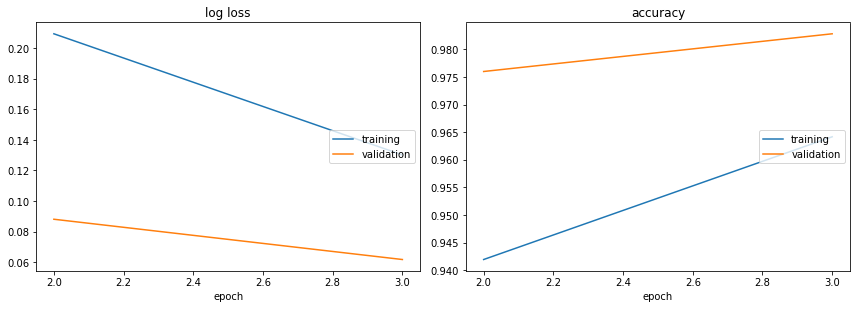

log loss:
training   (min:    0.130, max:    0.959, cur:    0.130)
validation (min:    0.062, max:    0.144, cur:    0.062)

accuracy:
training   (min:    0.685, max:    0.964, cur:    0.964)
validation (min:    0.957, max:    0.983, cur:    0.983)


In [0]:
from kmnist_helpers.model_selection import holdoutCV, holdout_loaders

# training parameters:
batch = 64
testbatch = 1000
epochs = 3

model = SimpleAlexNet_FINAL().to(device)

train_loader, val_loader = holdout_loaders(X, y, CustomImageTensorDataset, 
                                           batch, testbatch)
lloss, val_loss, val_acc = holdoutCV(epochs, 0.0, 1e-4, model,
                                     train_loader, val_loader)

### Save Cross Validation Logs

In [0]:
SimpleAlexNet_FINAL_logs = lloss.logs
f = open(F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/Model/SimpleAlexNet_FINAL_logs.pkl","wb")
pickle.dump(SimpleAlexNet_FINAL_logs,f)
f.close()

## Random-Grid Searching for Hyperparameters

We perform a random-grid search to find optimal hyperparameters.

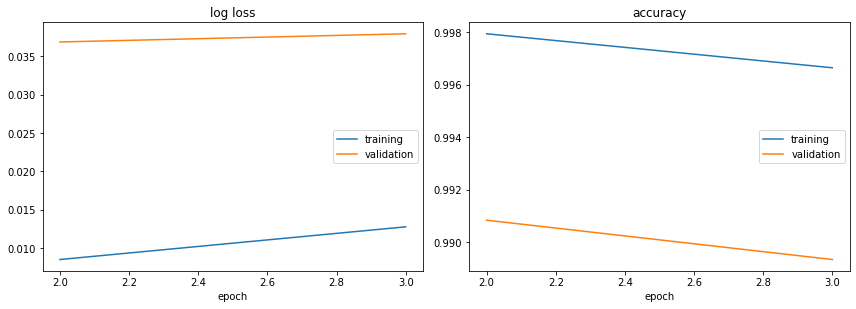

log loss:
training   (min:    0.008, max:    0.013, cur:    0.013)
validation (min:    0.037, max:    0.046, cur:    0.038)

accuracy:
training   (min:    0.997, max:    0.998, cur:    0.997)
validation (min:    0.989, max:    0.991, cur:    0.989)


In [0]:
from kmnist_helpers.tuning import RandomSearch, GridSearch

train_loader, val_loader = holdout_loaders(X, y, CustomImageTensorDataset, 
                                           batch, testbatch)

model = SimpleAlexNet_FINAL().to(device)

max_acc, rand_params = RandomSearch(5, model, 5,
                                    train_loader, val_loader)

best_comb, lloss, loss, acc = GridSearch(5, model, rand_params,
                                            train_loader, val_loader,
                                            pseudo=True)

## Final Full Training

We train the model onto the full training set and use the given test dataset for Kaggle.

In [0]:
# =============================Load Data======================================

X_train, y_train = torch.from_numpy(X).float(), torch.from_numpy(y) # Dummy Test Labels for y_test
X_test, y_test = torch.from_numpy(Xtest).float(), torch.from_numpy(np.array(range(X_test.shape[0]))).float() 

mean, std = torch.mean(X_train), torch.std(X_train)

train_ds = CustomImageTensorDataset(X_train, y_train.long(), transform=True, mean=mean, std=std)
test_ds = CustomImageTensorDataset(X_test, y_test.long(), transform=False, mean=mean, std=std)

batchsize = 100
testbatch = 1000
train_loader = DataLoader(train_ds, batch_size=batchsize, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=testbatch, shuffle=False, num_workers=0)

# =============================Train Model======================================

epochs = 30
model = SimpleAlexNet_FINAL().to(device)
set_seed(42)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999),
                             eps=1e-08, weight_decay=0.0, amsgrad=False)
criterion = nn.CrossEntropyLoss()
liveloss = PlotLosses()
for epoch in range(epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.
    
    liveloss.update(logs)
    liveloss.draw()

# ===================Train T-SNE and Logistic Regression========================

idx = np.where((y_train==2) | (y_train==6))
ytrainsim = y[idx]
Xtrainsim = X[idx]

tsne = TSNE(n_components=2, perplexity=3)
xtrain2d = np.reshape(Xtrainsim, (Xtrainsim.shape[0], -1))
xtrain2d = tsne.fit_transform(xtrain2d)

clf = LogisticRegression(random_state=seed, solver='lbfgs',
                         multi_class='multinomial').fit(xtrain2d, ytrainsim)

# ===========================T-SNE Recorrection=================================

y_predictions, _ = evaluate(model, test_loader)
idx = np.where((y_predictions==2) | (y_predictions==6))

ysim = y_predictions[idx]
Xsim = X_test[idx]

Xsim2d = np.reshape(Xsim, (Xsim.shape[0], -1))
Xsim2d = tsne.transform(Xsim2d)

y_predictions[idx] = clf.predict(Xsim2d)

# ===========================Predict Model======================================

y_predictions, _ = evaluate(model, test_loader)
submit = np.vstack((np.array(_), np.array(y_predictions)))
submit = submit.transpose()

### Ensemble modelling

In [0]:
from kmnist_helpers.ensemble import ensemble_validate, ensemble_score

model_list = [] # to be filled with pre-trained models on the cpu

train_loader_full = DataLoader(train_ds, batch_size=1000, shuffle=False, num_workers=0)
test_loader_full = DataLoader(test_ds, batch_size=1000, shuffle=False, num_workers=0)

ensemble_score = ensemble_validate(model_list, criterion=nn.CrossEntropyLoss(), data_loader=test_loader_full)
    
print('Score for the predictions of the ensembled models:', ensemble_score)

### Save Submissions

In [0]:
# Save the model
model_save_name = ".pt"
path = F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/Model/{model_save_name}" 
torch.save(model.state_dict(), path)

# Save the submission
output_save_name = ".txt"
path_out = F"/content/gdrive/My Drive/Colab Notebooks/Mini-Project/{output_save_name}"
np.savetxt(path_out, submit, delimiter=",", fmt='%d', header="Id,Category", comments='')